In [12]:
import os 
from pathlib import Path
import sys
import subprocess
import time
from typing import Optional
from collections import defaultdict 
import numpy as np
import matplotlib.pyplot as plt

In [13]:
executables = ['genmc', 'genmc-wkmo', 'genmc-xmm']
arguments_dict = {
    'genmc' : ['--v0', '--disable-race-detection', '--rc11'],
    'genmc-xmm' : ['--v0', '--XMM'],
    'genmc-wkmo' : ['--count-duplicate-execs', '--wkmo'],
}
tests = sorted([Path('tests') / t / 'variants' / v for t in os.listdir('tests') if os.path.isdir(Path('tests') / t) for v in os.listdir(Path('tests') / t / 'variants')])
subprocess_timeout = 1 #seconds

class RunExecutableResult:
    class Timeout:
        pass
    class Ok:
        def __init__(self, output) -> None:
            super().__init__()
            self.output = output
    class Error:
        def __init__(self, retcode, output) -> None:
            super().__init__()
            self.retcode = retcode
            self.output = output

def run_executable(exe_path: Path, args: list[str], test_path: Path) -> RunExecutableResult:
    try:
        result = subprocess.run([exe_path, *args, test_path], stdout=subprocess.PIPE, stderr=subprocess.PIPE, timeout=subprocess_timeout)
        result_stdout = result.stdout.decode()
        result_stderr = result.stderr.decode()
        if result.returncode == 0:
            return RunExecutableResult.Ok(result_stdout + result_stderr)
        else:
            return RunExecutableResult.Error(result.returncode, result_stdout + result_stderr)
    except subprocess.TimeoutExpired:
        return RunExecutableResult.Timeout()

In [14]:

def time_test(test_path: Path, repeat: int=1) -> Optional[dict[str, float]]:
    res = defaultdict(lambda: [])
    for exe in executables:
        args = arguments_dict[exe]
        for i in range(repeat):
            start_time = time.time()
            run_result = run_executable(Path('executables') / exe, args, test_path)
            if isinstance(run_result, RunExecutableResult.Timeout):
                res[exe].append(subprocess_timeout)
            elif isinstance(run_result, RunExecutableResult.Error):
                print("unexpected error occurred while executing", exe, *args, test_path)
                print(run_result.output)
            elif isinstance(run_result, RunExecutableResult.Ok):
                end_time = time.time()
                exe_time = end_time - start_time
                res[exe].append(exe_time)
            else:
                assert(False)
    
    for k in res:
        res[k] = np.mean(res[k])
    return res
    

In [15]:
time_test(tests[0], repeat=3)

results = defaultdict(lambda: [])
for test in tests:
    output = time_test(test, repeat=1)
    for k, v in output.items():
        results[k].append(v)

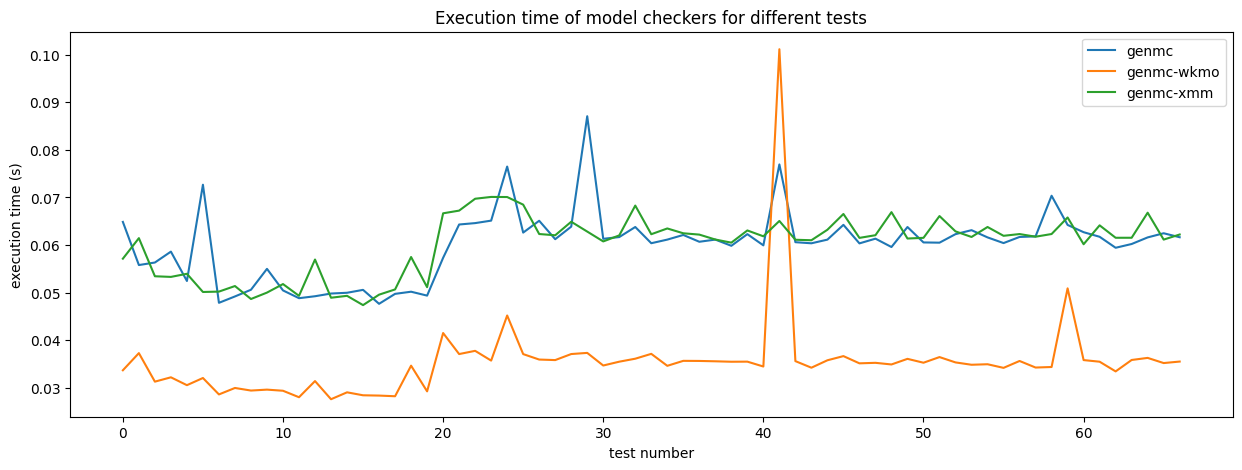

In [16]:
plt.figure(figsize=(15, 5))
for exe in executables:
    plt.plot(results[exe])
plt.legend(executables)
plt.xlabel("test number")
plt.ylabel("execution time (s)")
plt.title("Execution time of model checkers for different tests")
plt.show()

In [17]:
def bar_plot(values):
    labels = executables

    # Creating the bar plot
    plt.bar(labels, values, color=['blue', 'darkorange', 'darkgreen'])

    # Adding titles and labels
    plt.title('Total execution time over all tests')
    plt.ylabel('Total execution time')

    # Show the plot
    plt.show()

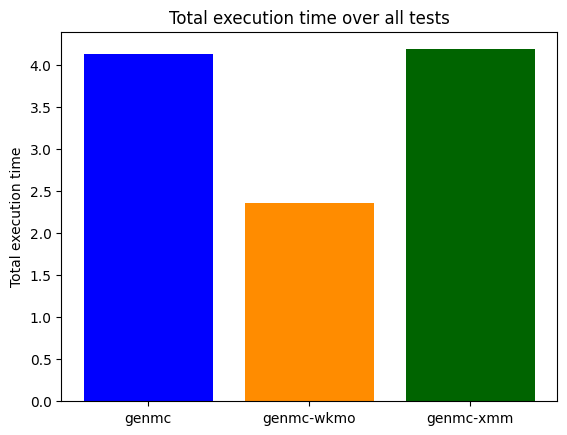

In [11]:
values = [sum(results[exe]) for exe in executables]

bar_plot(values)